Prerequisites – Download nltk stopwords and spacy model

In [1]:
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/weiweizheng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Import Packages

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

prepare stopwords

In [3]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['alexa', 'siri', 'heygoogle', 'cortana','would','could'])
# stop_words.extend(['alexa', 'siri', 'heygoogle', 'cortana', 'apple', 'google', 'amazon', 'microsoft'])

In [4]:
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

convert data to list

In [5]:
df = pd.read_csv('../data/text_071031_180729.csv', names = ['text'])
df = df.drop_duplicates()
data = df['text'].tolist()

In [6]:
df.head()

,text
0,"interesting times, interesting questions ! Ale..."
4,IOT NEWS: Not everyone likes digital voice ass...
5,Did you know that you can control your @dishne...
8,.@808_Audio wireless #speaker features #Alexa ...
9,@BigstickCarpet Awesome! I'm doing a workshop ...


In [7]:
df.shape

(128788, 1)

Tokenize words and Clean-up text

In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['interesting', 'times', 'interesting', 'questions', 'alexa', 'are', 'you', 'safe', 'for', 'my', 'kids', 'ai', 'alexa']]


Creating Bigram and Trigram Models

In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=200, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/Users/weiweizheng/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['interesting', 'times', 'interesting', 'questions', 'alexa', 'are', 'you', 'safe', 'for', 'my', 'kids', 'ai', 'alexa']


Remove Stopwords, Make Bigrams and Lemmatize

In [10]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['interesting', 'time', 'interesting', 'question', 'safe', 'kid', 'ai']]


Create the Dictionary and Corpus needed for Topic Modeling

In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1)]]


In [13]:
id2word[0]

'ai'

In [14]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]


[[('ai', 1),
  ('interesting', 2),
  ('kid', 1),
  ('question', 1),
  ('safe', 1),
  ('time', 1)]]

Building the Topic Model

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=37, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=500,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

 View the topics in LDA model

In [ ]:
# Print the Keyword in the 30 topics
pprint(lda_model.print_topics(num_words = 20))
doc_lda = lda_model[corpus]

Compute Model Perplexity and Coherence Score

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

Visualize the topics-keywords

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

Building LDA Mallet Model

In [25]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '../mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=37, id2word=id2word)

In [26]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False, num_words=20))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(35,
  [('googlehome', 0.10358936963215037),
   ('googleassistant', 0.08669583535893696),
   ('late', 0.07502835845081834),
   ('live', 0.06186193485658726),
   ('assistant', 0.04521147301895965),
   ('smartspeaker', 0.022565224436882192),
   ('daily', 0.022443688219089288),
   ('night', 0.018351968886728246),
   ('join', 0.016042780748663103),
   ('tonight', 0.014624858207745908),
   ('pm', 0.01405768919137903),
   ('bixby', 0.012680278723059471),
   ('djdurrant', 0.011991573488899692),
   ('googlehomemini', 0.01187003727110679),
   ('weekend', 0.011707988980716254),
   ('catch', 0.01118133203694701),
   ('ndcityapp', 0.009884945713822719),
   ('okgoogle', 0.009439312915248745),
   ('tunein', 0.00830497488251499),
   ('sunday', 0.008142926592124454)]),
 (10,
  [('ai', 0.22473812294995238),
   ('assistant', 0.07681726801396678),
   ('iot', 0.057948012555990545),
   ('chatbot', 0.025852643459245934),
   ('datum', 0.02564102564102564),
   ('cloud', 0.024406588368073925),
   ('machinelea

How to find the optimal number of topics for LDA?

In [21]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [22]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=1, limit=40, step=1)

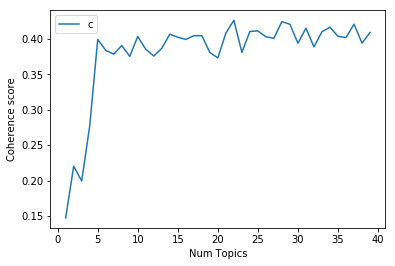

In [23]:
# Show graph
limit=40; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [24]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 1  has Coherence Value of 0.1472
Num Topics = 2  has Coherence Value of 0.2202
Num Topics = 3  has Coherence Value of 0.1993
Num Topics = 4  has Coherence Value of 0.2768
Num Topics = 5  has Coherence Value of 0.3992
Num Topics = 6  has Coherence Value of 0.384
Num Topics = 7  has Coherence Value of 0.3784
Num Topics = 8  has Coherence Value of 0.3906
Num Topics = 9  has Coherence Value of 0.3754
Num Topics = 10  has Coherence Value of 0.4035
Num Topics = 11  has Coherence Value of 0.3854
Num Topics = 12  has Coherence Value of 0.3759
Num Topics = 13  has Coherence Value of 0.3867
Num Topics = 14  has Coherence Value of 0.4066
Num Topics = 15  has Coherence Value of 0.4025
Num Topics = 16  has Coherence Value of 0.3992
Num Topics = 17  has Coherence Value of 0.4046
Num Topics = 18  has Coherence Value of 0.4046
Num Topics = 19  has Coherence Value of 0.3809
Num Topics = 20  has Coherence Value of 0.3732
Num Topics = 21  has Coherence Value of 0.4082
Num Topics = 22  has Co